In [39]:
import pandas as pd
import numpy as np
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_disable_xla_devices' # to run tensorflow on Mac M1 Pro (only one time)
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import sys

print(f"         Python: {sys.version} \n \
        TensorFlow: {tf.__version__} \n \
        Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

         Python: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ] 
         TensorFlow: 2.12.0 
         Num GPUs Available: 1


# 1. Input Image and Score

In [40]:
from PIL import Image
import os

# Resizing
# since tensorflow 2.11 does not support 'target_size' parameter in ImageDataGenerator
# The images should be resized manually

def resize(directory):
    if not os.path.exists(directory):
        os.makedirs(train_image_dir)

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # Open the image
            image = Image.open(os.path.join(directory, filename))

            # Resize the image
            image = image.resize(TARGET_SIZE)

            # Save the resized image
            output_path = os.path.join(directory, filename)
            image.save(output_path)

In [41]:
#resize(vali_image_dir)
#resize(test_image_dir)

In [42]:
# Load dataframe containing ImageID and Score
df_train = pd.read_csv("df_train.csv", header='infer', sep = ",")
df_vali = pd.read_csv("df_vali.csv", sep = ",")
df_test = pd.read_csv("df_test.csv", sep = ",")

In [43]:
df_train.head()

,ImageID,Score
0,244715,5.304348
1,310400,5.090426
2,744330,6.085890
3,126693,3.576642
4,645992,4.459821


In [44]:
# Score group
groups = np.linspace(start=0, stop=9, num=10)
df_train["Group"] = np.digitize(df_train["Score"], groups, right=True)
df_vali["Group"] = np.digitize(df_vali["Score"], groups, right=True)
df_test["Group"] = np.digitize(df_test["Score"], groups, right=True)

def smote_sampler(df):
    # Apply SMOTE to oversample the underrepresented group
    smote = SMOTE(sampling_strategy='not majority',k_neighbors=2, random_state = 12)
    X_resampled, y_resampled = smote.fit_resample(df[['ImageID', 'Score']], df['Group'])

    # Combine the original and resampled dataframes
    df_resampled = pd.concat([df_train, pd.DataFrame({'ImageID': X_resampled["ImageID"], 'Score': X_resampled["Score"], 'Group': y_resampled})], ignore_index=True)

    # Shuffle the resampled dataframe
    df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)
    return df_resampled

df_train_resampled = smote_sampler(df_train)
df_vali_resampled = smote_sampler(df_vali)

<Axes: ylabel='Frequency'>

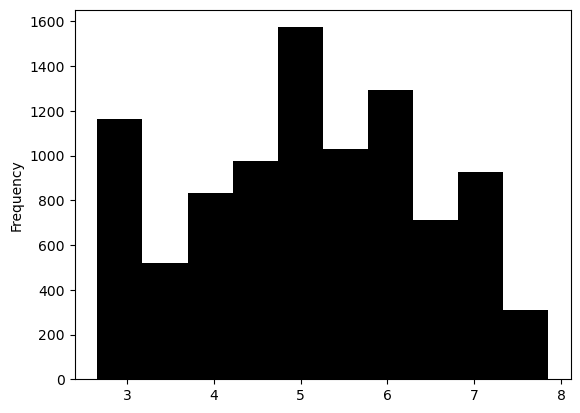

In [45]:
df_train_resampled["Score"].plot(kind = 'hist', color="black")

<Axes: ylabel='Frequency'>

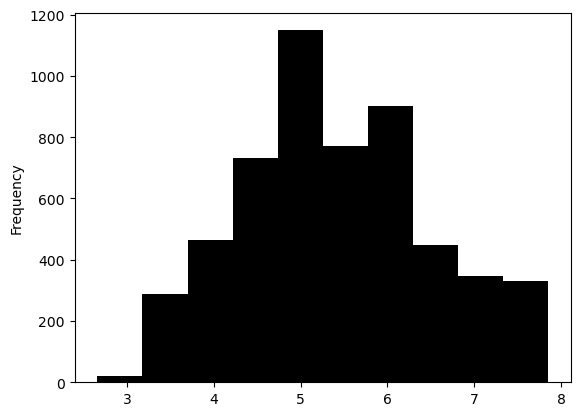

In [46]:
df_vali_resampled["Score"].plot(kind = 'hist', color="black")

In [47]:
def converting_dataframe(df):
    df["ImageID"] = df["ImageID"].astype(str) # Convert the ImageID column as string
    df['Score'] = df['Score'].astype(float) # Convert the Score column as float
    df = df.sort_values(by='ImageID') # Sorting the dataframe with ImageID
    df['ImageID_JPG'] = df['ImageID'].apply(lambda x: str(x) + '.jpg') # Image File (JPG) columns
    df['ImageID_JPG'] = df['ImageID_JPG'].astype(str)
    df = df.reset_index()
    return df

In [48]:
df_train_resampled = converting_dataframe(df_train_resampled)
df_vali_resampled = converting_dataframe(df_vali_resampled)
df_test = converting_dataframe(df_test)

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory containing images
train_image_dir = "/Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score/image/train"
vali_image_dir = "/Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score/image/validation"
test_image_dir = "/Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score/image/test"

# Define target image size and batch size
TARGET_SIZE = (299, 299)
BATCH_SIZE = 32
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = datagen.flow_from_dataframe(
    dataframe = df_train_resampled,
    directory = train_image_dir,
    x_col = "ImageID_JPG",
    y_col = "Score",
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw",
    data_format='channels_last',
    drop_duplicates = False)

vali_generator = datagen.flow_from_dataframe(
    dataframe = df_vali_resampled,
    directory = vali_image_dir,
    x_col = "ImageID_JPG",
    y_col = "Score",
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw",
    data_format='channels_last',
    drop_duplicates = False)

    
test_generator = datagen.flow_from_dataframe(
   dataframe = df_test,
   directory = test_image_dir,
   x_col = "ImageID_JPG",
   y_col = "Score",
   target_size = TARGET_SIZE,
   batch_size = 1,
   class_mode = None,
   data_format='channels_last',
   shuffle = False)

Found 5075 validated image filenames.
Found 1260 validated image filenames.
Found 1247 validated image filenames.


/Users/user/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4255 invalid image filename(s) in x_col="ImageID_JPG". These filename(s) will be ignored.
  warnings.warn(
/Users/user/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4196 invalid image filename(s) in x_col="ImageID_JPG". These filename(s) will be ignored.
  warnings.warn(


In [123]:
train_generator = train_gen(df_train_resampled, train_image_dir)
vali_generator = train_gen(df_vali_resampled, vali_image_dir)
test_generator = test_gen(df_test, test_image_dir)

Found 5075 validated image filenames.
Found 1260 validated image filenames.
Found 1247 validated image filenames.


/Users/user/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4255 invalid image filename(s) in x_col="ImageID_JPG". These filename(s) will be ignored.
  warnings.warn(
/Users/user/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 4196 invalid image filename(s) in x_col="ImageID_JPG". These filename(s) will be ignored.
  warnings.warn(


In [127]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(generator):
    # Check image and label
    images, labels = next(generator) 
    print(f" Image: {images.shape} \n Label: {labels.shape}")

    # Visualize the image data
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Score: {labels[i]:.2f}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

 Image: (32, 299, 299, 3) 
 Label: (32,)


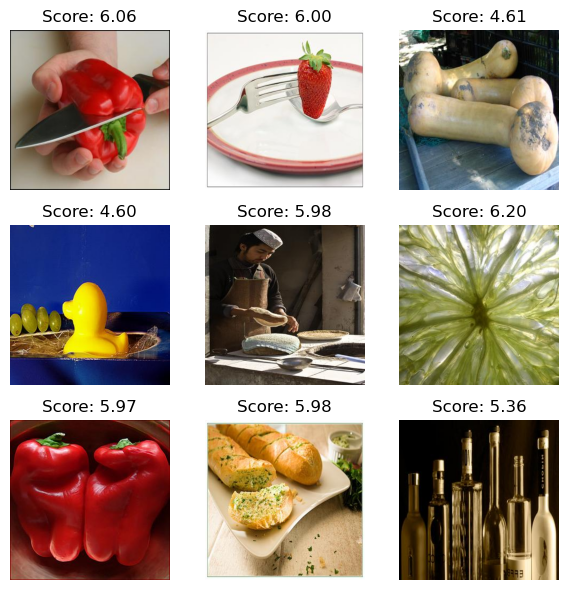

 Image: (32, 299, 299, 3) 
 Label: (32,)


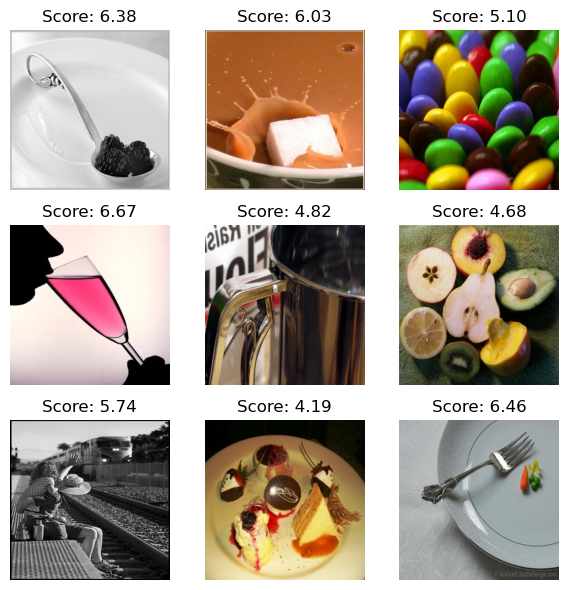

In [128]:
visualize(train_generator)
visualize(vali_generator)

# 3. Model Training

In [58]:
# Baseline model

from tensorflow.keras.applications.xception import Xception
from keras import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam # legacy -> get Tensorflow working on M1 Pro Chip
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, Dropout


input_shape = (299,299,3)
base = Xception(weights="imagenet", include_top=False, input_shape=input_shape, pooling='avg')

# Freeze the layers so that they are not updated
for layer in base.layers:
    layer.trainable = False

# Add new layers
model = Sequential()
model.add(base)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu')) # Rectified Linear Unit
model.add(Dense(32, activation='relu')) # not activate all the neurons at the same time
model.add(Dense(1, activation='linear'))


# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,134,121
Trainable params: 272,641
Non-trainable params: 20,861,480
_________________________________________________________________


In [34]:
# Callback to save the best model and Early Stopping to stop early if the validation loss stops improving
#import os
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_disable_xla_devices'
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('xception_resampled.h5', save_best_only=True, save_weights_only=True,
                             monitor='val_loss', mode='min', verbose=1)

earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

history1 = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=8, 
                   validation_data=vali_generator, validation_steps=vali_generator.n//vali_generator.batch_size,
                   callbacks=[checkpoint, earlystop])

Epoch 1/8


/var/folders/dy/83hbn4852jjfst1bvkpcw1hr0000gn/T/ipykernel_6818/2153074246.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=8,


158/158 [==============================] - ETA: 0s - loss: 1.8397 - mean_absolute_error: 0.9890
Epoch 1: val_loss improved from inf to 0.93780, saving model to xception_resampled.h5
158/158 [==============================] - 72s 450ms/step - loss: 1.8397 - mean_absolute_error: 0.9890 - val_loss: 0.9378 - val_mean_absolute_error: 0.7691
Epoch 2/8
158/158 [==============================] - ETA: 0s - loss: 0.6976 - mean_absolute_error: 0.6612
Epoch 2: val_loss improved from 0.93780 to 0.93338, saving model to xception_resampled.h5
158/158 [==============================] - 71s 447ms/step - loss: 0.6976 - mean_absolute_error: 0.6612 - val_loss: 0.9334 - val_mean_absolute_error: 0.7621
Epoch 3/8
158/158 [==============================] - ETA: 0s - loss: 0.5027 - mean_absolute_error: 0.5637
Epoch 3: val_loss improved from 0.93338 to 0.74686, saving model to xception_resampled.h5
158/158 [==============================] - 71s 447ms/step - loss: 0.5027 - mean_absolute_error: 0.5637 - val_loss:

In [35]:
# Unfreeze all layers and re-train the combined model on AVA dataset

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history2 = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=4, 
                   validation_data=vali_generator, validation_steps=vali_generator.n//vali_generator.batch_size,
                   callbacks=[checkpoint, earlystop])

Epoch 1/4


/var/folders/dy/83hbn4852jjfst1bvkpcw1hr0000gn/T/ipykernel_6818/2305545678.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=4,


158/158 [==============================] - ETA: 0s - loss: 0.3484 - mean_absolute_error: 0.4534
Epoch 1: val_loss improved from 0.67185 to 0.62901, saving model to xception_resampled.h5
158/158 [==============================] - 209s 1s/step - loss: 0.3484 - mean_absolute_error: 0.4534 - val_loss: 0.6290 - val_mean_absolute_error: 0.6223
Epoch 2/4
158/158 [==============================] - ETA: 0s - loss: 0.1683 - mean_absolute_error: 0.3030
Epoch 2: val_loss improved from 0.62901 to 0.52174, saving model to xception_resampled.h5
158/158 [==============================] - 204s 1s/step - loss: 0.1683 - mean_absolute_error: 0.3030 - val_loss: 0.5217 - val_mean_absolute_error: 0.5610
Epoch 3/4
158/158 [==============================] - ETA: 0s - loss: 0.0973 - mean_absolute_error: 0.2323
Epoch 3: val_loss improved from 0.52174 to 0.48583, saving model to xception_resampled.h5
158/158 [==============================] - 204s 1s/step - loss: 0.0973 - mean_absolute_error: 0.2323 - val_loss: 0

Text(0.5, 1.0, 'Train 2/Validation Accuracy per Epoch (MAE)')

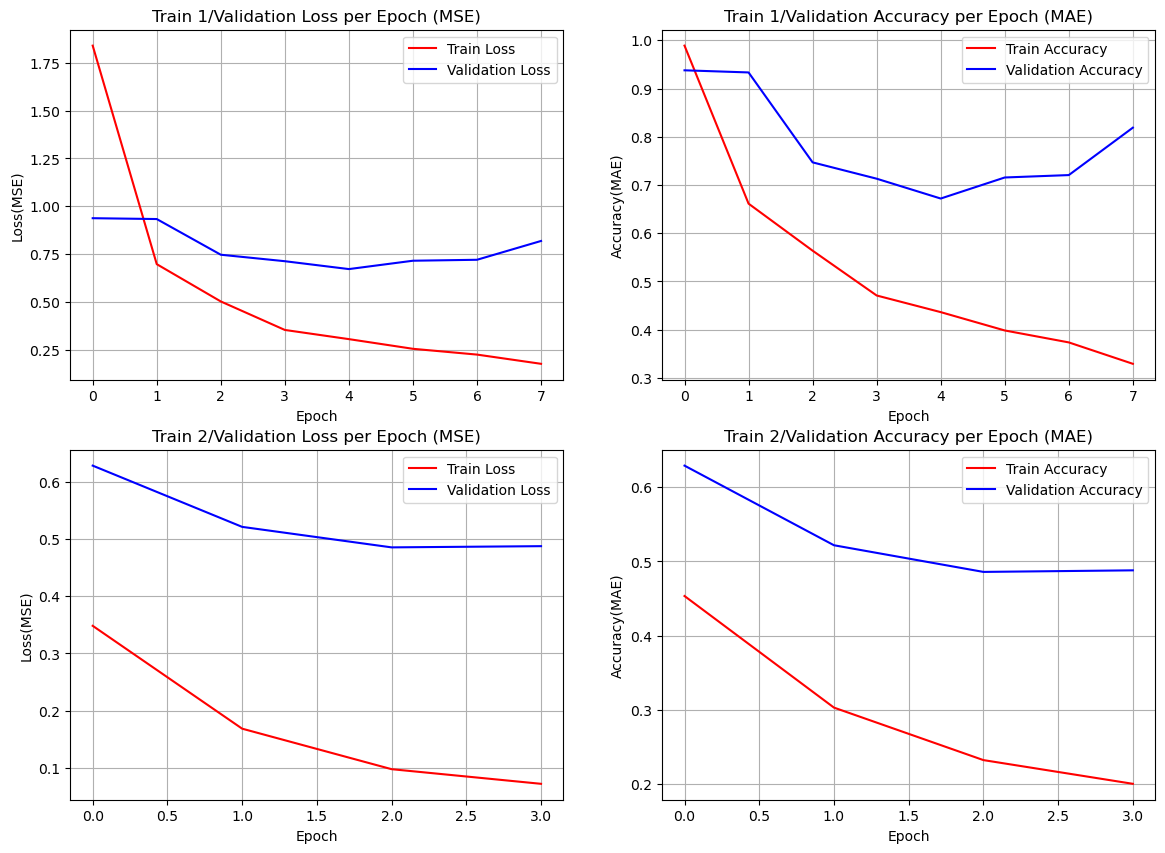

In [36]:
figure, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,10))

# Train1 - Plot for the training/validation loss per epoch

ax[0,0].plot(history1.history['loss'], label='Train Loss', c='red')
ax[0,0].plot(history1.history['val_loss'], label='Validation Loss', c='blue')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss(MSE)')
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_title('Train 1/Validation Loss per Epoch (MSE)')

# Train1 - Plot for the training/validation accuracy per epoch

ax[0,1].plot(history1.history['mean_absolute_error'], label='Train Accuracy',  c='red')
ax[0,1].plot(history1.history['val_loss'], label='Validation Accuracy', c='blue')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Accuracy(MAE)')
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_title('Train 1/Validation Accuracy per Epoch (MAE)')


# Train 2 - Plot for the training/validation loss per epoch

ax[1,0].plot(history2.history['loss'], label='Train Loss', c='red')
ax[1,0].plot(history2.history['val_loss'], label='Validation Loss', c='blue')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss(MSE)')
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_title('Train 2/Validation Loss per Epoch (MSE)')

# Train 2 - Plot for the training/validation accuracy per epoch

ax[1,1].plot(history2.history['mean_absolute_error'], label='Train Accuracy', c='red')
ax[1,1].plot(history2.history['val_loss'], label='Validation Accuracy', c='blue')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Accuracy(MAE)')
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_title('Train 2/Validation Accuracy per Epoch (MAE)')

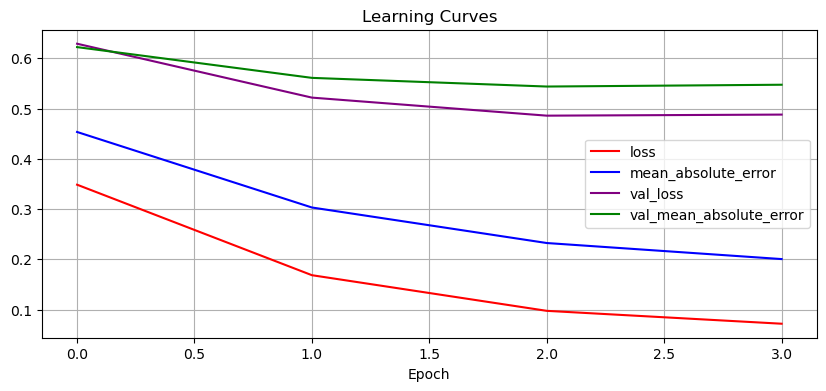

In [37]:
# Plot for the entire history

color_dict = {'loss': 'red', 'mean_absolute_error': 'blue', 
              'val_loss': 'purple', 'val_mean_absolute_error': 'green' }
pd.DataFrame(history2.history).plot(figsize=(10,4), color=color_dict)
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.xlabel("Epoch")
plt.title("Learning Curves")
plt.show()

In [172]:
model.save_weights("aesthetic_regressor/")

# 4. Hyperparameter Tuning

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam # legacy -> get Tensorflow working on M1 Pro Chip
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Define the model builder function
def build_model(hp):
    base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

    # Freeze the base layers
    for layer in base.layers:
        layer.trainable = False

    # Define the model architecture
    model = keras.Sequential()
    model.add(base)
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
 
    
    # Compile the model with a chosen optimizer, learning rate, and loss function
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse', metrics=['mae'])

    # Unfreeze the base layers
    for layer in base.layers:
        layer.trainable = True

    # Compile the model with a chosen optimizer, learning rate, and loss function
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])), 
                  loss='mse', metrics=['mae'])
    
    return model

# Define the Keras Tuner random search
tuner = RandomSearch(build_model, objective='val_loss', max_trials=3, executions_per_trial=2, 
                     directory='my_dir', project_name='my_project')

# Train the model with the tuner
tuner.search(train_generator, validation_data=vali_generator, epochs=10)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp)

# Build the best model and train it on the entire training dataset
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(train_generator, epochs=10, validation_data=vali_generator)

Trial 5 Complete [01h 15m 00s]
val_loss: 1.0001104474067688

Best val_loss So Far: 0.5761389136314392
Total elapsed time: 06h 10m 07s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
159/159 [==============================] - 242s 1s/step - loss: 235.1426 - mae: 1.8941 - val_loss: 36.1876 - val_mae: 3.9663
Epoch 2/10
159/159 [==============================] - 225s 1s/step - loss: 0.5940 - mae: 0.6270 - val_loss: 0.5805 - val_mae: 0.6138
Epoch 3/10
159/159 [==============================] - 224s 1s/step - loss: 0.5870 - mae: 0.6219 - val_loss: 0.6630 - val_mae: 0.6448
Epoch 4/10
159/159 [==============================] - 224s 1s/step - loss: 0.6030 - mae: 0.6300 - val_loss: 0.5902 - val_mae: 0.6341
Epoch 5/10
159/159 [==============================] - 224s 1s/step - loss: 0.6058 - mae: 0.6297 - val_loss: 0.6169 - val_mae: 0.6236
Epoch 6/10
159/159 [==============================] - 225s 1s/step - loss: 0.6004 - mae: 0.6296 - val_loss: 0.5763 - val_mae: 0.6216
Epoch 7/10
159/159 [==============================] - 223s 1s/step - loss: 0.5867 - mae: 0.6245 - val_loss: 0.5911 - val_mae: 0.6347
Epoch 8/10
159/159 [==============================] - 222s 1s/step

In [106]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dense_4 (Dense)             (None, 10, 10, 384)       786816    
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_5 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_6 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 384)      

In [107]:
# Save the best model
best_model.save('/Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score')

# Trial 3 Complete [01h 14m 59s]
# val_loss: 6.389198571443558

# Best val_loss So Far: 6.389198571443558
# Total elapsed time: 01h 14m 59s

# Search: Running Trial #1

# Value             |Best Value So Far |Hyperparameter
# 448               |256               |dense_units
# 0                 |0.2               |dropout_rate
# 0.001             |0.001              |learning_rate

INFO:tensorflow:Assets written to: /Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score/assets


INFO:tensorflow:Assets written to: /Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score/assets


In [116]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dense_4 (Dense)             (None, 10, 10, 384)       786816    
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_5 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_6 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 384)      

In [115]:
temp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dense_4 (Dense)             (None, 10, 10, 384)       786816    
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_5 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_6 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 384)      

In [117]:
# Load the saved model

from tensorflow import keras

model = keras.models.load_model('/Users/user/Desktop/Projects/CMSE890 - Image Aesthetic Score')

In [118]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dense_4 (Dense)             (None, 10, 10, 384)       786816    
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_5 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_6 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 384)      

In [119]:
base = model
base.add(Flatten())
base.add(Dense(1, activation='linear'))
base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dense_4 (Dense)             (None, 10, 10, 384)       786816    
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_5 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 384)       0         
                                                                 
 dense_6 (Dense)             (None, 10, 10, 384)       147840    
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 384)      

# 5. Test the Model

In [129]:
# Evaluate the model on the test dataset

test_loss, test_mae = model.evaluate(test_generator)
print(f' Test Loss: {test_loss} \n Test MAE: {test_mae}')

1247/1247 [==============================] - 4s 3ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
 Test Loss: 0.0 
 Test MAE: 0.0


In [130]:
# Predict the scores for the test dataset
test_generator.reset()
y_pred = model.predict(test_generator, verbose = 1)

# Print the predicted scores
print(y_pred)

1247/1247 [==============================] - 40s 29ms/step
[[4.7831116]
 [4.7831116]
 [4.7831116]
 ...
 [4.7831116]
 [4.7831116]
 [4.7831116]]


In [131]:
# True Score
y_true = []
test_filenames = test_generator.filenames

for filename in test_filenames:
    score = df_test[df_test["ImageID_JPG"] == filename]["Score"].values[0]  # extract the score for the image
    y_true.append(score)
y_true = np.array(y_true)

# Compare y_pred with y_score
mse = np.mean(np.square(y_pred - y_true))
mae = np.mean(np.abs(y_pred - y_true))

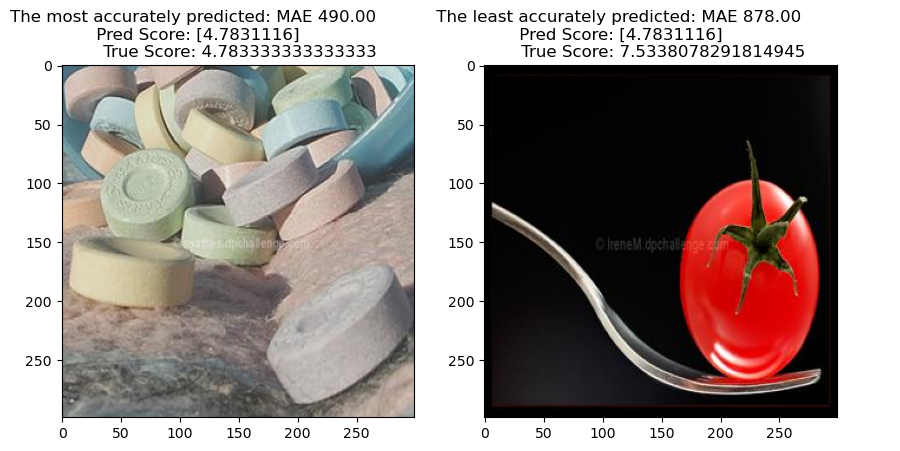

In [132]:
from tensorflow.keras.utils import load_img

# Predict 
#y_pred = model.predict(test_generator)

# True Score
y_true = []
test_filenames = test_generator.filenames

for filename in test_filenames:
    score = df_test[df_test["ImageID_JPG"] == filename]["Score"].values[0]  # extract the score for the image
    y_true.append(score)
y_true = np.array(y_true)

# Calculate error (MAE) and save the corresponding index
errors = abs(y_pred[:,0] - y_true)
max_error_index = np.argmax(errors)
min_error_index = np.argmin(errors)

# Find the filenames for the images
filenames = test_generator.filenames
max_error_filename = os.path.join(test_image_dir, filenames[max_error_index])
min_error_filename = os.path.join(test_image_dir, filenames[min_error_index])

# Call the images
max_error_image = load_img(max_error_filename)
min_error_image = load_img(min_error_filename)

# Display the images
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(min_error_image)
ax[0].set_title(f'The most accurately predicted: MAE {np.argmin(errors):.2f} \
                \n Pred Score: {y_pred[min_error_index]}\
                \n True Score: {y_true[min_error_index]}')
ax[1].imshow(max_error_image)
ax[1].set_title(f' The least accurately predicted: MAE {np.argmax(errors):.2f} \
                \n Pred Score: {y_pred[max_error_index]}\
                \n True Score: {y_true[max_error_index]}')
plt.show()

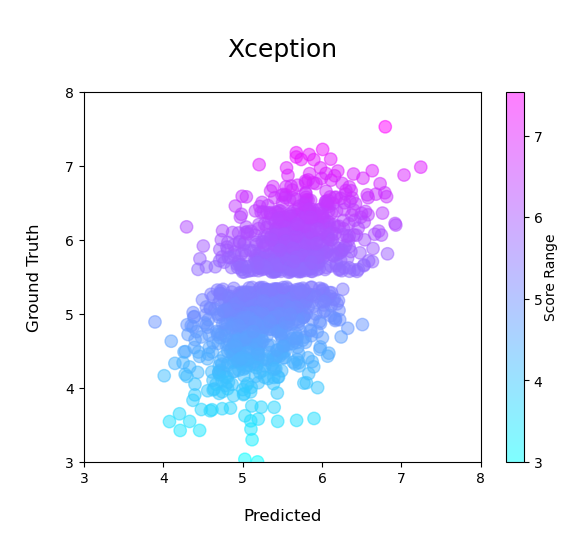

In [49]:
import matplotlib.pyplot as plt



x = y_pred
y = df_test["Score"]
colors = df_test["Score"]
area = 80

plt.title("\nXception \n Coefficient of Determination", fontsize=14)
plt.xlabel("\nPredicted\n", fontsize=12)
plt.ylabel("\nGround Truth\n", fontsize=12)
marker_size=15

plt.scatter(x, y, s=area, c=colors, cmap='cool', alpha=0.5)
plt.xlim([3, 8])
plt.ylim([3, 8])

cbar = plt.colorbar()
cbar.set_label("Score Range", labelpad=+1)

plt.show()

In [43]:
# R2

from sklearn.metrics import r2_score

r2_score(y_true, y_pred)

0.2603554663284151

In [44]:
# MAE 
from sklearn.metrics import median_absolute_error

median_absolute_error(y_true, y_pred)

0.4357765552609463

In [45]:
# MSE 

from sklearn.metrics import mean_squared_error

mean_squared_error(y_true, y_pred)

0.40491013469264536